# Book Popularity Prediction


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
import joblib


In [2]:
csv_path = 'book_data.csv'
print("Set csv_path =", csv_path)


Set csv_path = book_data.csv


In [6]:
df = pd.read_csv(csv_path)
print("Raw shape:", df.shape)
display(df.head(3))
display(df.columns.tolist())


Raw shape: (9671, 12)


,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.780000e+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.780000e+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.780000e+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...


['book_authors',
 'book_desc',
 'book_edition',
 'book_format',
 'book_isbn',
 'book_pages',
 'book_rating',
 'book_rating_count',
 'book_review_count',
 'book_title',
 'genres',
 'image_url']

In [7]:
def clean_dataframe(df):
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    expected = ['book_authors','book_desc','book_edition','book_format','book_isbn',
                'book_pages','book_rating','book_rating_count','book_review_count',
                'book_title','genres','image_url']
    present = [c for c in expected if c in df.columns]
    print("Present expected columns:", present)
    if 'book_pages' in df.columns:
        df['book_pages'] = df['book_pages'].astype(str).str.replace(r'[^0-9]', '', regex=True)
        df['book_pages'] = pd.to_numeric(df['book_pages'], errors='coerce').fillna(0).astype(int)
    else:
        df['book_pages'] = 0
    for col in ['book_rating','book_rating_count','book_review_count']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        else:
            df[col] = 0
    for tcol in ['book_desc','book_title','book_authors','genres']:
        if tcol in df.columns:
            df[tcol] = df[tcol].fillna('').astype(str)
        else:
            df[tcol] = ''
    df['genres_clean'] = df['genres'].str.replace(r'[|;]', ',', regex=True).str.lower()
    return df

df = clean_dataframe(df)
print("Cleaned shape:", df.shape)
display(df.head(2))
df.to_csv('book_data_cleaned.csv', index=False)
print("Saved book_data_cleaned.csv")


Present expected columns: ['book_authors', 'book_desc', 'book_edition', 'book_format', 'book_isbn', 'book_pages', 'book_rating', 'book_rating_count', 'book_review_count', 'book_title', 'genres', 'image_url']
Cleaned shape: (9671, 13)


,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url,genres_clean
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.780000e+12,374,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...,"young adult,fiction,science fiction,dystopia,f..."
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.780000e+12,870,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...,"fantasy,young adult,fiction"


Saved book_data_cleaned.csv


In [8]:
quantile = 0.90
thr = df['book_review_count'].quantile(quantile)
print(f"Using quantile={quantile}, threshold={thr:.2f} for 'popular' label")
df['popular_book'] = (df['book_review_count'] >= thr).astype(int)
display(df['popular_book'].value_counts(normalize=True))


Using quantile=0.9, threshold=7939.00 for 'popular' label


,proportion
popular_book,
0,0.899907
1,0.100093


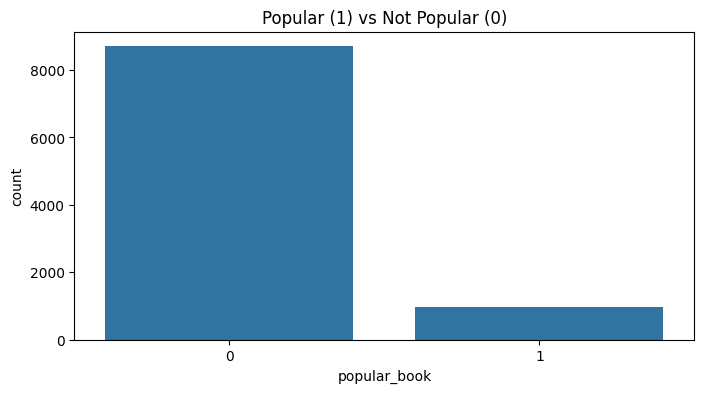

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(x='popular_book', data=df)
plt.title('Popular (1) vs Not Popular (0)')
plt.show()


In [17]:
text_col = 'book_desc'
numeric_cols = ['book_pages','book_rating','book_rating_count']

empty_desc_frac = (df['book_desc'].str.strip() == '').mean()
if empty_desc_frac > 0.25:
    df['combined_text'] = (df['book_title'].fillna('') + ' ' + df['book_authors'].fillna('') + ' ' + df['book_desc'].fillna('')).str.strip()
    text_col = 'combined_text'

X = df[[text_col] + numeric_cols]
y = df['popular_book']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [19]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('tfidf', tfidf, text_col),
    ('num', scaler, numeric_cols)
])

pipe_lr = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga'))])
pipe_rf = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))])


In [20]:
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print("LR F1:", f1_score(y_test, y_pred_lr, zero_division=0))
print(classification_report(y_test, y_pred_lr, zero_division=0))


LR Accuracy: 0.9410852713178295
LR F1: 0.75
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1731
           1       0.68      0.84      0.75       204

    accuracy                           0.94      1935
   macro avg       0.83      0.90      0.86      1935
weighted avg       0.95      0.94      0.94      1935



In [21]:
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF F1:", f1_score(y_test, y_pred_rf, zero_division=0))
print(classification_report(y_test, y_pred_rf, zero_division=0))


RF Accuracy: 0.9116279069767442
RF F1: 0.27848101265822783
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1731
           1       1.00      0.16      0.28       204

    accuracy                           0.91      1935
   macro avg       0.96      0.58      0.62      1935
weighted avg       0.92      0.91      0.88      1935



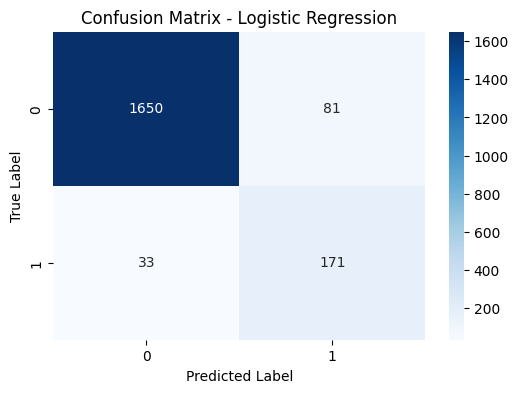

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

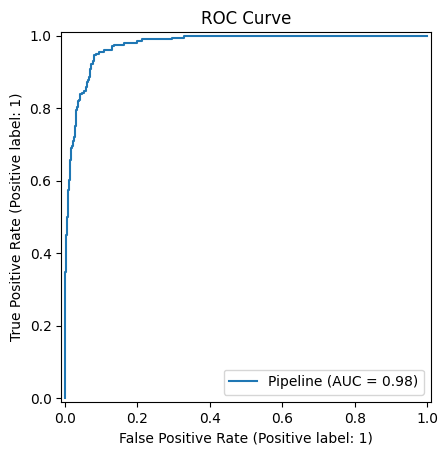

In [27]:
RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test)
plt.title('ROC Curve')
plt.show()

In [29]:
y_proba = pipe_lr.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC-AUC score: {roc_auc:.4f}')

ROC-AUC score: 0.9761


In [22]:
joblib.dump(pipe_lr, 'book_popularity_lr_pipeline.pkl')
joblib.dump(pipe_rf, 'book_popularity_rf_pipeline.pkl')
df.to_csv('book_data_cleaned.csv', index=False)
print("Saved models and cleaned data")
files.download('book_data_cleaned.csv')
files.download('book_popularity_lr_pipeline.pkl')
files.download('book_popularity_rf_pipeline.pkl')


Saved models and cleaned data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>